In [7]:
import pandas as pd
df = pd.read_csv('/content/combined_champions_league_stats.csv')
print(df)

     Rk            Squad  MP  W  D  L  GF  GA  GD  Pts    xG   xGA   xGD  \
0     1         Dortmund   6  4  1  1  10   2   8   13  10.5   4.1   6.5   
1     2  Atlético Madrid   6  4  1  1   9   6   3   13   6.2   5.8   0.4   
2     3      Club Brugge   6  1  3  2   6   5   1    6   5.4   6.3  -0.9   
3     4           Monaco   6  0  1  5   2  14 -12    1   5.1  11.0  -5.9   
4     1        Barcelona   6  4  2  0  14   5   9   14  10.4   8.6   1.9   
..   ..              ...  .. .. .. ..  ..  ..  ..  ...   ...   ...   ...   
219   4        Wolfsburg   6  1  2  3   5  10  -5    5   4.8  11.1  -6.2   
220   1         Juventus   6  5  0  1  10   6   4   15  11.2   6.8   4.3   
221   2          Chelsea   6  4  1  1  13   4   9   13  12.8   5.5   7.3   
222   3            Zenit   6  1  2  3  10  10   0    5   9.8   8.0   1.9   
223   4            Malmö   6  0  1  5   1  14 -13    1   1.6  15.1 -13.5   

     xGD/90  Eliminated  Eliminating  Score  Value      Sezon     Grup  
0      1.08   

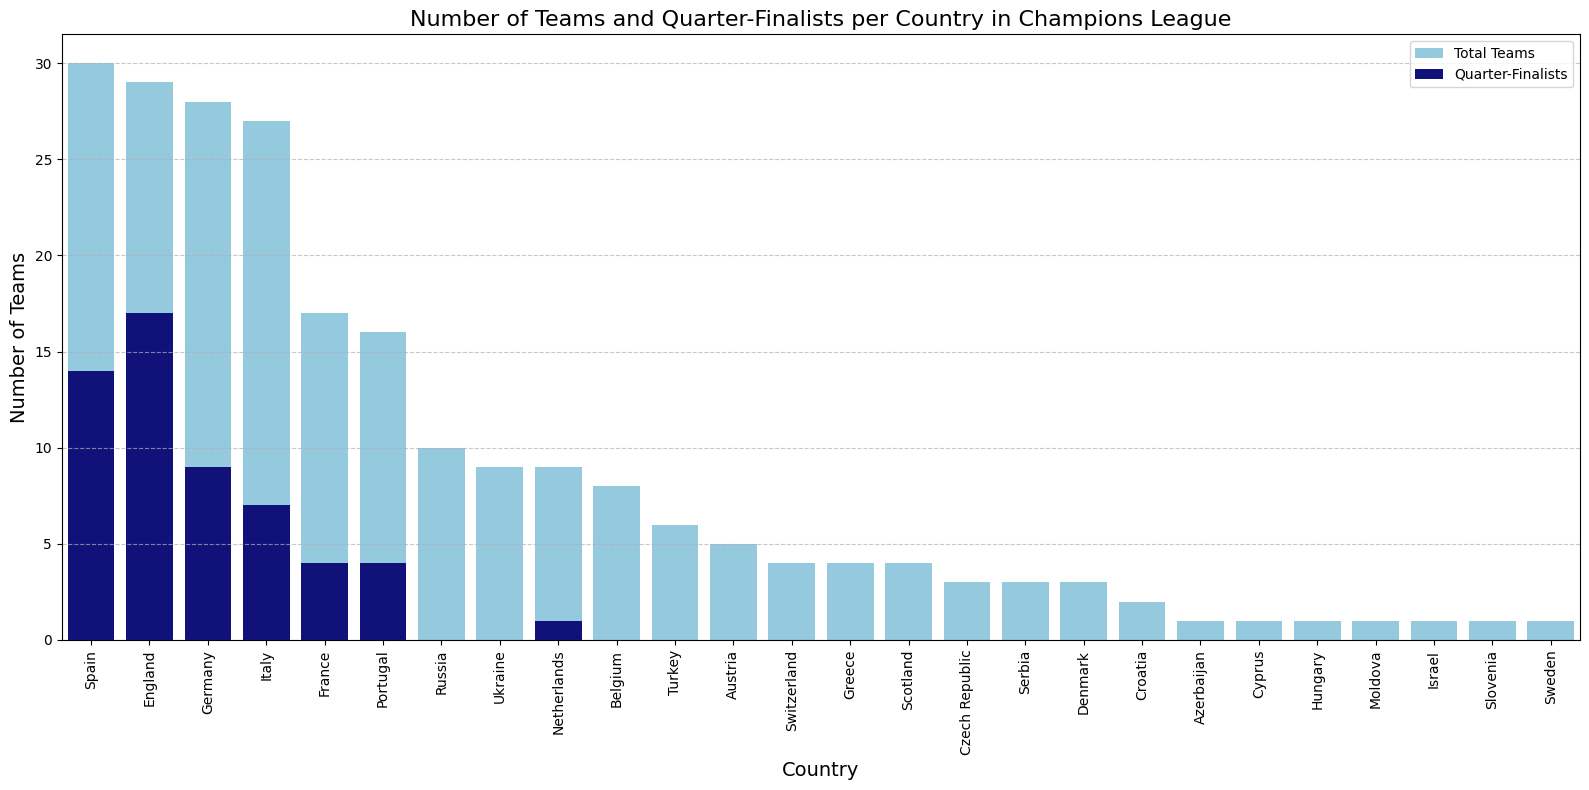

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure df is loaded
if 'df' not in locals():
    df = pd.read_csv('/content/combined_champions_league_stats.csv')

# Load the team-to-country mapping from the CSV file
try:
    country_map_df = pd.read_csv('/content/team_country_mapping.csv')
    # Merge the main dataframe with the country mapping dataframe
    # Using 'left' merge to keep all rows from df and add Country information
    df = pd.merge(df, country_map_df, on='Squad', how='left', suffixes=('', '_new'))
    # If 'Country' column existed before and a new one was merged, consolidate it
    if 'Country_new' in df.columns:
        if 'Country' in df.columns and not df['Country'].isnull().all():
            # If original 'Country' had values, prefer them unless new is not null
            df['Country'] = df['Country'].fillna(df['Country_new'])
        else:
            # If original 'Country' was empty or didn't exist, use the new one
            df['Country'] = df['Country_new']
        df = df.drop(columns=['Country_new'])
    # After a successful merge, if the 'Country' column still doesn't exist
    # (e.g., country_map_df was empty or had no matching 'Squad' column name, though unlikely)
    if 'Country' not in df.columns:
        df['Country'] = None # Initialize to None if it's still missing
        print("Warning: 'Country' column was not established after merging with team_country_mapping.csv.")

except FileNotFoundError:
    print("Error: 'team_country_mapping.csv' not found. 'Country' column will not be available for mapping.")
    df['Country'] = None # Ensure 'Country' column exists even if mapping file is missing
except Exception as e:
    print(f"An unexpected error occurred during country mapping: {e}")
    df['Country'] = None # Fallback for other errors

# Check for any teams that weren't mapped to a country after merging
unmapped_teams = df[df['Country'].isna()]['Squad'].unique()
if len(unmapped_teams) > 0:
    print(f"Warning: The following teams were not mapped to a country and have NaN in the 'Country' column: {unmapped_teams}")

# Count total teams per country
total_teams_per_country = df.groupby('Country')['Squad'].count().reset_index()
total_teams_per_country.rename(columns={'Squad': 'Total Teams'}, inplace=True)

# Count quarter-finalist teams per country (Eliminated > 1 means reached at least R16, so for quarter-finals it should be > 2)
# 'Eliminated' column values:
# 0 = Group stage elimination
# 1 = Round of 16 elimination
# 2 = Quarter-final elimination
# 3 = Semi-final elimination
# 4 = Finalist (runner-up)
# 5 = Winner
# So, for quarter-finals or further: Eliminated >= 2
quarter_finalists_per_country = df[df['Eliminated'] >= 2].groupby('Country')['Squad'].count().reset_index()
quarter_finalists_per_country.rename(columns={'Squad': 'Quarter-Finalists'}, inplace=True)

# Merge the two dataframes
merged_data = pd.merge(total_teams_per_country, quarter_finalists_per_country, on='Country', how='left').fillna(0)

# Convert counts to integer type for better display
merged_data['Total Teams'] = merged_data['Total Teams'].astype(int)
merged_data['Quarter-Finalists'] = merged_data['Quarter-Finalists'].astype(int)

# Sort by total teams for better visualization
merged_data = merged_data.sort_values(by='Total Teams', ascending=False)

# Create the bar chart
plt.figure(figsize=(16, 8))

# Plot total teams
sns.barplot(x='Country', y='Total Teams', data=merged_data, color='skyblue', label='Total Teams')

# Plot quarter-finalists on top
sns.barplot(x='Country', y='Quarter-Finalists', data=merged_data, color='darkblue', label='Quarter-Finalists')

plt.title('Number of Teams and Quarter-Finalists per Country in Champions League', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Teams', fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

0     1.08
1     0.07
8     0.83
13    0.35
16    1.31
Name: xGD/90, dtype: float64
5     0.69
9     1.20
40    1.23
52   -0.43
80    2.41
Name: xGD/90, dtype: float64
Mean xGD/90 for Round of 16 teams: 0.50
Mean xGD/90 for Finalist teams: 1.28


/tmp/ipython-input-286801804.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='xGD/90', data=combined_xgd, palette=['skyblue', 'lightcoral'])


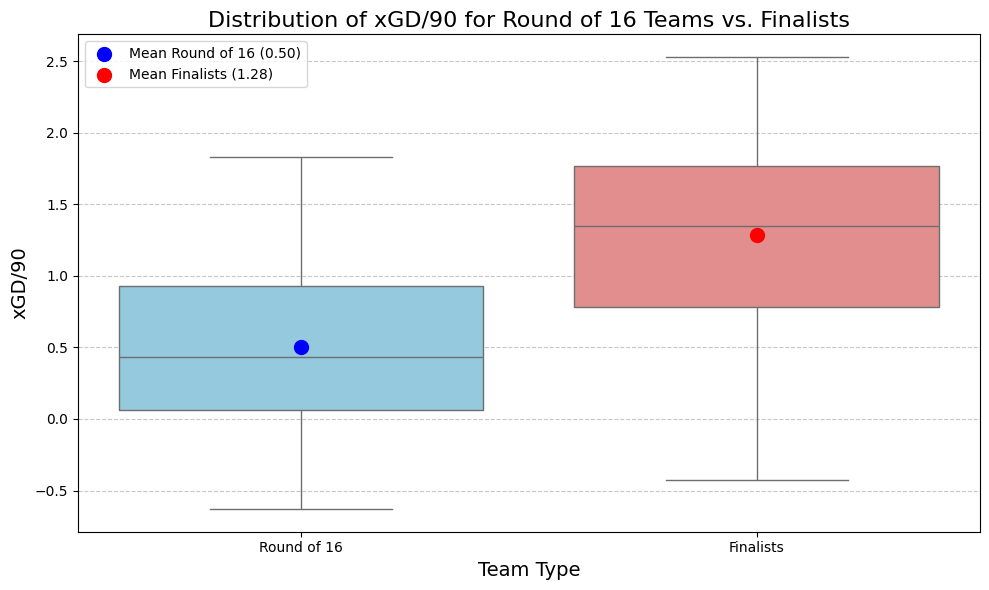

T-statistic: 4.21
P-value: 0.0000769463
The null hypothesis (that the means are equal) can be rejected by independent t-test.


In [8]:
round_of_16_xgd = df[df['Eliminated'] == 1]['xGD/90']
print(round_of_16_xgd.head())

finalist_xgd = df[df['Eliminated'].isin([4, 5])]['xGD/90']
print(finalist_xgd.head())

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Calculate the mean of the 'xGD/90' values for teams eliminated in the Round of 16
mean_round_of_16_xgd = round_of_16_xgd.mean()
print(f"Mean xGD/90 for Round of 16 teams: {mean_round_of_16_xgd:.2f}")

# 2. Calculate the mean of the 'xGD/90' values for finalist teams
mean_finalist_xgd = finalist_xgd.mean()
print(f"Mean xGD/90 for Finalist teams: {mean_finalist_xgd:.2f}")

# Prepare data for seaborn boxplot
combined_xgd = pd.DataFrame({
    'xGD/90': pd.concat([round_of_16_xgd, finalist_xgd]),
    'Group': ['Round of 16'] * len(round_of_16_xgd) + ['Finalists'] * len(finalist_xgd)
})

# 4. Create a figure and an axes object for the plot
plt.figure(figsize=(10, 6))

# 5. Use sns.boxplot() to create box plots for both groups
sns.boxplot(x='Group', y='xGD/90', data=combined_xgd, palette=['skyblue', 'lightcoral'])

# 6. Add horizontal lines or markers to represent the calculated mean 'xGD/90' for each group
plt.scatter(x=[0], y=[mean_round_of_16_xgd], color='blue', marker='o', s=100, label=f'Mean Round of 16 ({mean_round_of_16_xgd:.2f})', zorder=5)
plt.scatter(x=[1], y=[mean_finalist_xgd], color='red', marker='o', s=100, label=f'Mean Finalists ({mean_finalist_xgd:.2f})', zorder=5)

# 7. Add a title to the plot
plt.title('Distribution of xGD/90 for Round of 16 Teams vs. Finalists', fontsize=16)

# 8. Label the x-axis and the y-axis
plt.xlabel('Team Type', fontsize=14)
plt.ylabel('xGD/90', fontsize=14)

# 9. Add a legend
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 10. Display the plot
plt.tight_layout()
plt.show()
from scipy.stats import ttest_ind

# Perform independent two-sample t-test, putting the group with the larger mean first
t_statistic, p_value = ttest_ind(finalist_xgd, round_of_16_xgd)

# Print the results with p-value formatted to 10 decimal places
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.10f}")
if p_value < 0.05:
    print("The null hypothesis (that the means are equal) can be rejected by independent t-test.")
else :
  print("The null hypothesis (that the means are equal) cannot be rejected by independent t-test.")

Mean Value for Round of 16 teams: 522.79
Mean Value for Finalist teams: 819.64

T-statistic (Value): 3.61
P-value (Value): 0.0005777713


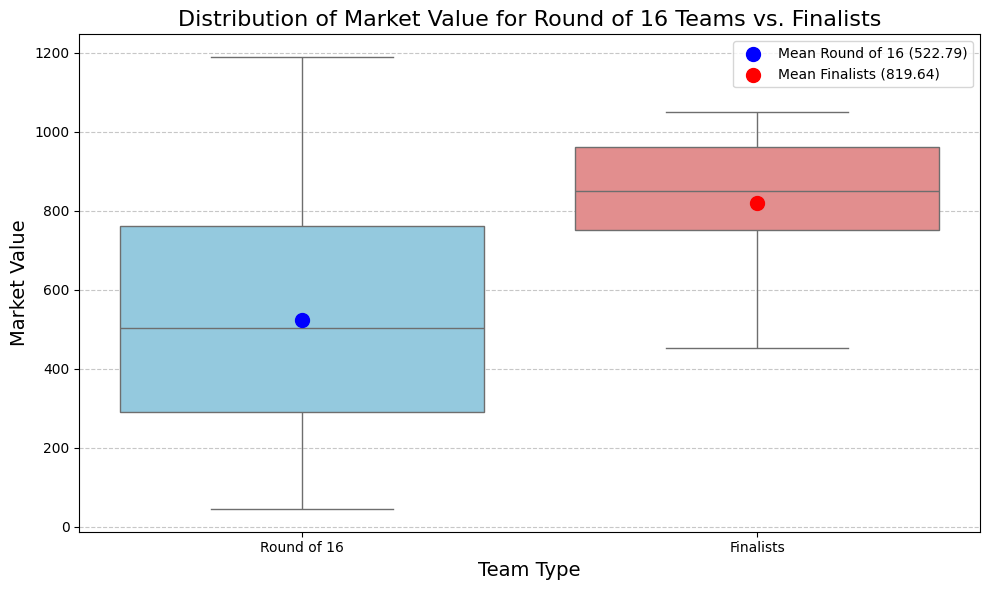

The null hypothesis (that the means are equal) can be rejected by independent t-test.


In [20]:
# Filter 'Value' for Round of 16 teams
round_of_16_value = df[df['Eliminated'] == 1]['Value']
print(f"Mean Value for Round of 16 teams: {round_of_16_value.mean():.2f}")

# Filter 'Value' for Finalist teams
finalist_value = df[df['Eliminated'].isin([4, 5])]['Value']
print(f"Mean Value for Finalist teams: {finalist_value.mean():.2f}")

# Perform independent two-sample t-test
t_statistic_value, p_value_value = ttest_ind(finalist_value, round_of_16_value)

# Print the results with p-value formatted to 10 decimal places
print(f"\nT-statistic (Value): {t_statistic_value:.2f}")
print(f"P-value (Value): {p_value_value:.10f}")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for seaborn boxplot
combined_value = pd.DataFrame({
    'Value': pd.concat([round_of_16_value, finalist_value]),
    'Group': ['Round of 16'] * len(round_of_16_value) + ['Finalists'] * len(finalist_value)
})

# Create a figure and an axes object for the plot
plt.figure(figsize=(10, 6))

# Use sns.boxplot() to create box plots for both groups with hue and palette specified
sns.boxplot(x='Group', y='Value', data=combined_value, hue='Group', palette=['skyblue', 'lightcoral'], legend=False)

# Add horizontal lines or markers to represent the calculated mean 'Value' for each group
plt.scatter(x=[0], y=[round_of_16_value.mean()], color='blue', marker='o', s=100, label=f'Mean Round of 16 ({round_of_16_value.mean():.2f})', zorder=5)
plt.scatter(x=[1], y=[finalist_value.mean()], color='red', marker='o', s=100, label=f'Mean Finalists ({finalist_value.mean():.2f})', zorder=5)

# Add a title to the plot
plt.title('Distribution of Market Value for Round of 16 Teams vs. Finalists', fontsize=16)

# Label the x-axis and the y-axis
plt.xlabel('Team Type', fontsize=14)
plt.ylabel('Market Value', fontsize=14)

# Add a legend
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
if p_value_value < 0.05:
    print("The null hypothesis (that the means are equal) can be rejected by independent t-test.")
else :
  print("The null hypothesis (that the means are equal) can be rejected by independent t-test.")

Mean Pts for Round of 16 teams: 11.73
Mean Pts for Finalist teams: 13.71

T-statistic (Pts): 2.66
P-value (Pts): 0.0096509695


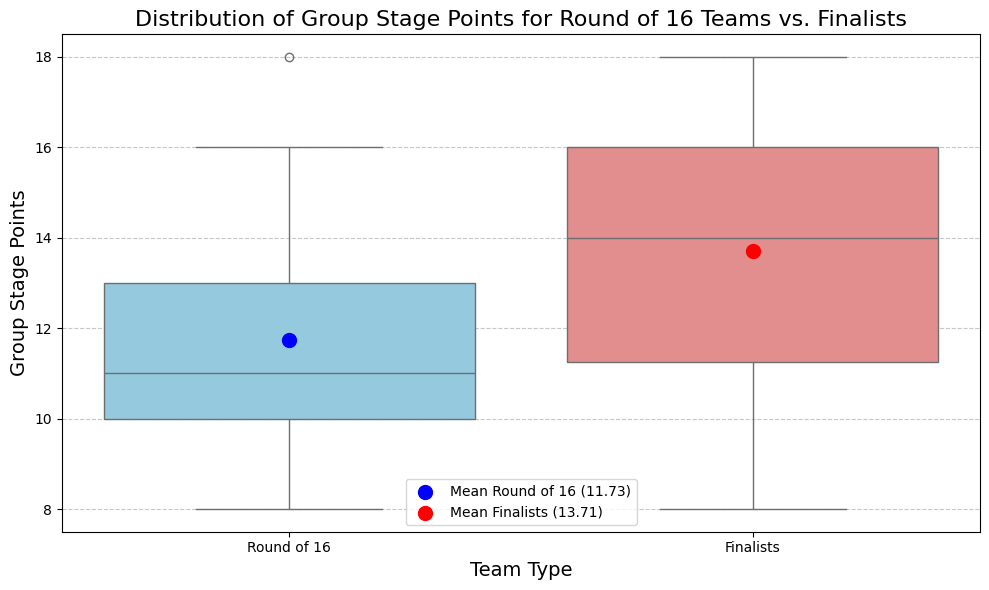

The null hypothesis (that the means are equal) can be rejected by independent t-test.


In [21]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter 'Pts' for Round of 16 teams
round_of_16_pts = df[df['Eliminated'] == 1]['Pts']
print(f"Mean Pts for Round of 16 teams: {round_of_16_pts.mean():.2f}")

# Filter 'Pts' for Finalist teams
finalist_pts = df[df['Eliminated'].isin([4, 5])]['Pts']
print(f"Mean Pts for Finalist teams: {finalist_pts.mean():.2f}")

# Perform independent two-sample t-test, putting the group with the larger mean first
t_statistic_pts, p_value_pts = ttest_ind(finalist_pts, round_of_16_pts)

# Print the results with p-value formatted to 10 decimal places
print(f"\nT-statistic (Pts): {t_statistic_pts:.2f}")
print(f"P-value (Pts): {p_value_pts:.10f}")

# Prepare data for seaborn boxplot
combined_pts = pd.DataFrame({
    'Pts': pd.concat([round_of_16_pts, finalist_pts]),
    'Group': ['Round of 16'] * len(round_of_16_pts) + ['Finalists'] * len(finalist_pts)
})

# Create a figure and an axes object for the plot
plt.figure(figsize=(10, 6))

# Use sns.boxplot() to create box plots for both groups with hue and palette specified
sns.boxplot(x='Group', y='Pts', data=combined_pts, hue='Group', palette=['skyblue', 'lightcoral'], legend=False)

# Add horizontal lines or markers to represent the calculated mean 'Pts' for each group
plt.scatter(x=[0], y=[round_of_16_pts.mean()], color='blue', marker='o', s=100, label=f'Mean Round of 16 ({round_of_16_pts.mean():.2f})', zorder=5)
plt.scatter(x=[1], y=[finalist_pts.mean()], color='red', marker='o', s=100, label=f'Mean Finalists ({finalist_pts.mean():.2f})', zorder=5)

# Add a title to the plot
plt.title('Distribution of Group Stage Points for Round of 16 Teams vs. Finalists', fontsize=16)

# Label the x-axis and the y-axis
plt.xlabel('Team Type', fontsize=14)
plt.ylabel('Group Stage Points', fontsize=14)

# Add a legend
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
if p_value_value < 0.05:
    print("The null hypothesis (that the means are equal) can be rejected by independent t-test.")
else :
  print("The null hypothesis (that the means are equal) can be rejected by independent t-test.")

In [22]:
from scipy.stats import chi2_contingency
import pandas as pd

# Ensure df is loaded in case of kernel restart or out-of-order execution
df = pd.read_csv('/content/combined_champions_league_stats.csv')

# Create a 'Group Winner' column (True if Rk == 1, False otherwise)
df['Group_Winner'] = (df['Rk'] == 1)

# Create a 'Finalist_Status' column (True if Eliminated is 4 or 5, False otherwise)
df['Finalist_Status'] = df['Eliminated'].isin([4, 5])

# Create a contingency table
contingency_table = pd.crosstab(df['Group_Winner'], df['Finalist_Status'])

print("Contingency Table (Group Winner vs. Finalist Status):\n", contingency_table)

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.10f}")
print(f"Degrees of Freedom: {dof}")
# print("Expected Frequencies Table:\n", expected)
if p_value_value < 0.05:
    print("The null hypothesis can be rejected by chi-square test.")
else :
  print("The null hypothesis cannot be rejected by chi-square test..")

Contingency Table (Group Winner vs. Finalist Status):
 Finalist_Status  False  True 
Group_Winner                 
False              164      4
True                46     10

Chi-square Statistic: 14.63
P-value: 0.0001309147
Degrees of Freedom: 1
The null hypothesis can be rejected by chi-square test.


Mean GD for Round of 16 teams: 4.77
Mean GD for Finalist teams: 9.64

T-statistic (GD): 3.53
P-value (GD): 0.0007526411


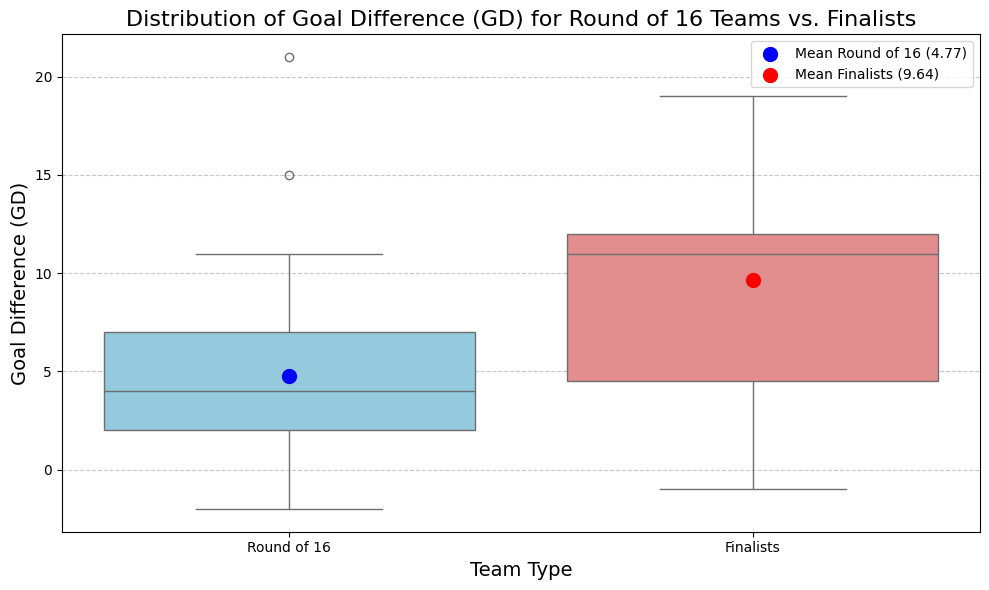

The null hypothesis can be rejected by chi-square test.


In [5]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure df is loaded in case of kernel restart or out-of-order execution
if 'df' not in locals():
    df = pd.read_csv('/content/combined_champions_league_stats.csv')

# Filter 'GD' for Round of 16 teams
round_of_16_gd = df[df['Eliminated'] == 1]['GD']
print(f"Mean GD for Round of 16 teams: {round_of_16_gd.mean():.2f}")

# Filter 'GD' for Finalist teams
finalist_gd = df[df['Eliminated'].isin([4, 5])]['GD']
print(f"Mean GD for Finalist teams: {finalist_gd.mean():.2f}")

# Perform independent two-sample t-test, putting the group with the larger mean first
t_statistic_gd, p_value_gd = ttest_ind(finalist_gd, round_of_16_gd)

# Print the results with p-value formatted to 10 decimal places
print(f"\nT-statistic (GD): {t_statistic_gd:.2f}")
print(f"P-value (GD): {p_value_gd:.10f}")

# Prepare data for seaborn boxplot
combined_gd = pd.DataFrame({
    'GD': pd.concat([round_of_16_gd, finalist_gd]),
    'Group': ['Round of 16'] * len(round_of_16_gd) + ['Finalists'] * len(finalist_gd)
})

# Create a figure and an axes object for the plot
plt.figure(figsize=(10, 6))

# Use sns.boxplot() to create box plots for both groups with hue and palette specified
sns.boxplot(x='Group', y='GD', data=combined_gd, hue='Group', palette=['skyblue', 'lightcoral'], legend=False)

# Add horizontal lines or markers to represent the calculated mean 'GD' for each group
plt.scatter(x=[0], y=[round_of_16_gd.mean()], color='blue', marker='o', s=100, label=f'Mean Round of 16 ({round_of_16_gd.mean():.2f})', zorder=5)
plt.scatter(x=[1], y=[finalist_gd.mean()], color='red', marker='o', s=100, label=f'Mean Finalists ({finalist_gd.mean():.2f})', zorder=5)

# Add a title to the plot
plt.title('Distribution of Goal Difference (GD) for Round of 16 Teams vs. Finalists', fontsize=16)

# Label the x-axis and the y-axis
plt.xlabel('Team Type', fontsize=14)
plt.ylabel('Goal Difference (GD)', fontsize=14)

# Add a legend
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
if p_value_gd < 0.05:
  print("The null hypothesis can be rejected by independent t-test.")
else :
  print("The null hypothesis cannot be rejected by independent t-test..")